In [10]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
from PIL import Image
import cv2
import numpy as np
import os, random,sys
from PIL import Image


# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [11]:
# Unzip the lfw.zip file in the sample_data directory
!unzip /content/lfw.zip -d /content/lfw


Streaming output truncated to the last 5000 lines.
  inflating: /content/lfw/lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0021.jpg  
  inflating: /content/lfw/__MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0021.jpg  
  inflating: /content/lfw/lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0020.jpg  
  inflating: /content/lfw/__MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0020.jpg  
  inflating: /content/lfw/lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0008.jpg  
  inflating: /content/lfw/__MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0008.jpg  
  inflating: /content/lfw/lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0022.jpg  
  inflating: /content/lfw/__MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0022.jpg  
  inflating: /content/lfw/lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0023.jpg  
  inflating: /content/lfw/__MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0023.jpg  
  inflating: /content/lfw/lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_

In [12]:
path = '/content/lfw/lfw'

In [13]:
transform = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform), batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [14]:
if torch.cuda.is_available():
    # Check if MPS is available
    if torch.backends.mps.is_available():
        device = torch.device("mps")
        print("Using MPS device.")
    else:
        device = torch.device("cuda")
        print("Using CUDA device.")
else:
    # If CUDA is not available, use CPU
    device = torch.device("cpu")
    print("CUDA not available. Using CPU.")

CUDA not available. Using CPU.


torch.Size([250, 250, 3])


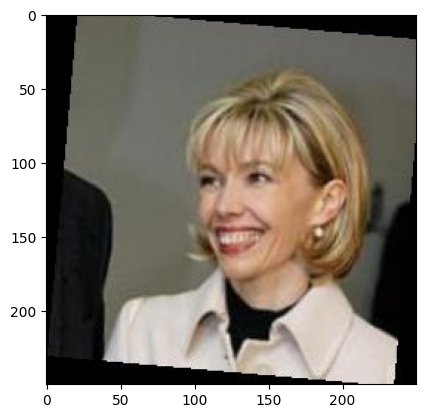

In [15]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

In [16]:
# Get one batch from the DataLoader
for x, y in dataloader:
    # Print dimensions
    print(f"Sample dimensions: {x[0].shape}")
    break


Sample dimensions: torch.Size([3, 250, 250])


**The** dimensions represent the shape of the image, typically in the form (channels, height, width) or (height, width, channels), depending on the library and conventions used.
C (Channels): Represents the color channels in the image.
H (Height): Represents the number of pixels along the vertical axis.
W (Width): Represents the number of pixels along the horizontal axis.

# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import random
import os

class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 8, kernel_size=2, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.ConvTranspose2d(8, 3, kernel_size=2, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
ae_model = AE()


## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [18]:
# Instantiate the model
ae_model = AE()

# Create a dummy input tensor mimicking an RGB image of size 256x256
# (batch_size, channels, height, width)
dummy_input = torch.randn(1, 3, 256, 256)  # Assuming a batch size of 1

# Forward pass through the model
with torch.no_grad():
    ae_model.eval()

    # Forward pass through the encoder
    encoded_output = ae_model.encoder(dummy_input)
    print(f"Encoder output shape: {encoded_output.shape}")

    # Forward pass through the decoder
    decoded_output = ae_model.decoder(encoded_output)
    print(f"Decoder output shape: {decoded_output.shape}")

Encoder output shape: torch.Size([1, 64, 16, 16])
Decoder output shape: torch.Size([1, 3, 253, 253])


##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [19]:
import torch.optim as optim

total_params = sum(p.numel() for p in ae_model.parameters())
print(f'Total Parameters: {total_params}')

loss_function =torch.nn.MSELoss()
# Create an optimizer for training
optimizer = optim.Adam(ae_model.parameters(), lr=0.001)


Total Parameters: 43403


For training, the Mean Squared Error (MSE) loss function is used. It is ideal for image reconstruction tasks as it minimizes the pixel-wise difference between the original and reconstructed images. The optimizer, Adam, with a learning rate of 0.001, is chosen for its efficiency in updating the model's parameters, balancing the speed and stability of learning.

##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [20]:
# Set the number of training epochs
num_epochs = 10

# Move the model to the selected device (CPU or GPU)
ae_model.to(device)

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0

    # Iterate over the dataset
    for inputs, _ in dataloader:
        inputs = inputs.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = ae_model(inputs)

        # Compute the loss without resizing
        loss = loss_function(outputs, inputs[:, :, :outputs.size(2), :outputs.size(3)])

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update the running loss
        running_loss += loss.item()

    # Print the average loss for the epoch
    average_loss = running_loss / len(dataloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {average_loss}")

    # Check if the loss is not decreasing
    if epoch > 0 and average_loss >= prev_loss:
        print("Warning: Loss is not decreasing!")

    prev_loss = average_loss

# Save the trained model
torch.save(ae_model.state_dict(), 'autoencoder_model.pth')


Epoch 1/10, Loss: 0.026507469038096605
Epoch 2/10, Loss: 0.007940165660285575
Epoch 3/10, Loss: 0.006745518590121165
Epoch 4/10, Loss: 0.006162038613965618
Epoch 5/10, Loss: 0.005732267778951692
Epoch 6/10, Loss: 0.005431293658372285
Epoch 7/10, Loss: 0.005181416202165582
Epoch 8/10, Loss: 0.004957182609570631
Epoch 9/10, Loss: 0.0047882748340315005
Epoch 10/10, Loss: 0.004615508505269201


If the loss is not decreasing during the training of your autoencoder, it indicates that the model is not learning effectively. Here are some steps to troubleshoot this issue:


*   Adjust Learning Rate
*   Increase Epochs
*   Review Data Preprocessing
*   Check Model Architecture
*   Inspect Loss Function
*   Batch Size Adjustment

##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

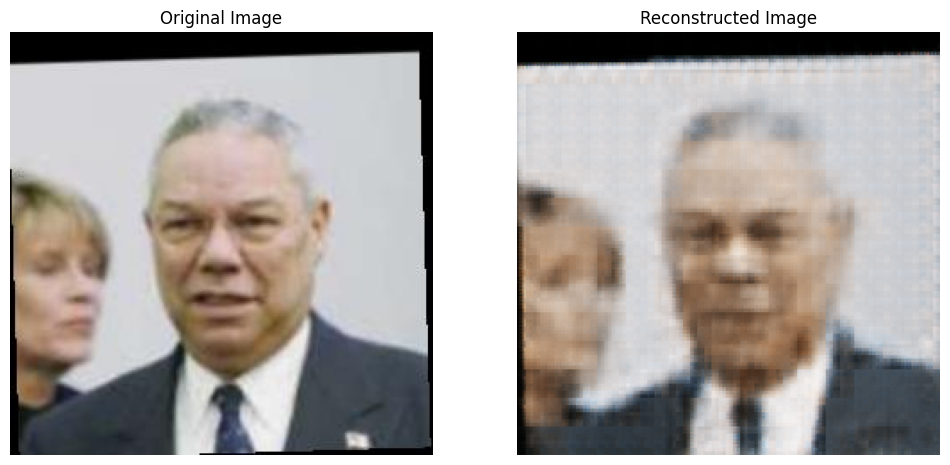

In [35]:
# Get a single batch from the dataloader
dataiter = iter(dataloader)
images, _ = next(dataiter)

# Select the first image from the batch
original_image = images[0]
original_image_np = original_image.numpy().transpose(1, 2, 0)

# Move the image to the device and add a batch dimension
input_image = original_image.unsqueeze(0).to(device)

# Pass the image through your autoencoder
with torch.no_grad():
    reconstructed = ae_model(input_image)
    reconstructed_np = reconstructed.cpu().squeeze(0).numpy().transpose(1, 2, 0)

# Ensure that the pixel values are in the [0, 1] range
reconstructed_np = np.clip(reconstructed_np, 0, 1)

# Plot the original and reconstructed images
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(original_image_np)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_np)
plt.title("Reconstructed Image")
plt.axis('off')

plt.show()


##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

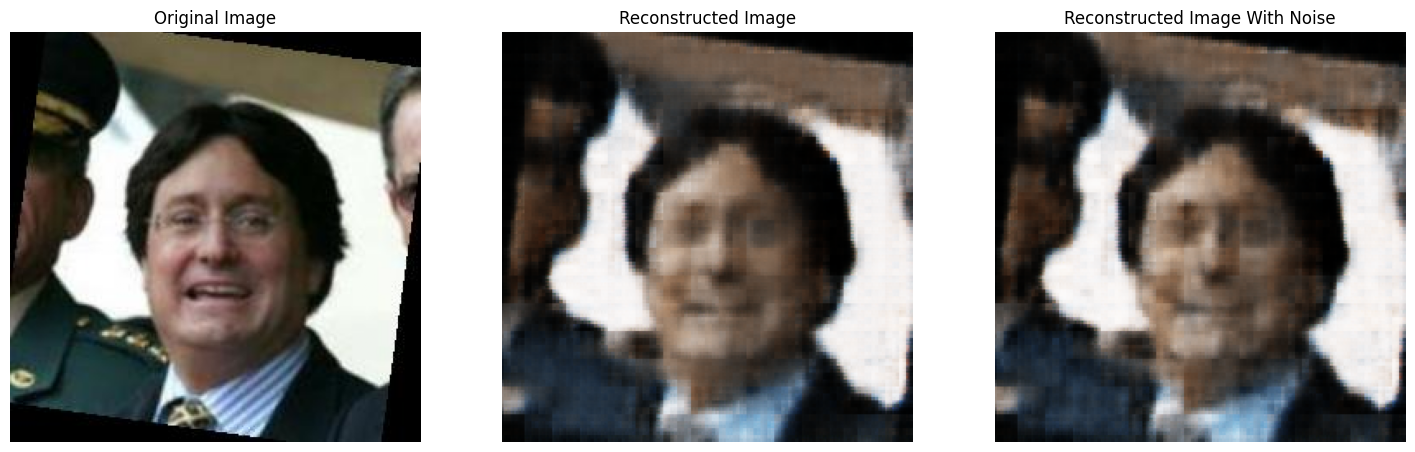

In [27]:
# Get a single batch from the dataloader
dataiter = iter(dataloader)
images, _ = next(dataiter)

# Select the first image from the batch
original_image = images[0]
original_image_np = original_image.numpy().transpose(1, 2, 0)

# Move the image to the device and add a batch dimension
input_image = original_image.unsqueeze(0).to(device)

# Pass the image through your autoencoder
with torch.no_grad():
    # First decode without noise
    reconstructed = ae_model(input_image)
    reconstructed_np = reconstructed.cpu().squeeze(0).numpy().transpose(1, 2, 0)

    # Then add noise to the latent representation
    encoded = ae_model.encoder(input_image)
    noise = torch.randn_like(encoded) * 0.2  # You can adjust the noise factor here
    encoded_with_noise = encoded + noise

    # Decode the noisy encoded representation
    decoded_with_noise = ae_model.decoder(encoded_with_noise)
    reconstructed_with_noise_np = decoded_with_noise.cpu().squeeze(0).numpy().transpose(1, 2, 0)

# Ensure that the pixel values are in the [0, 1] range
reconstructed_np = np.clip(reconstructed_np, 0, 1)
reconstructed_with_noise_np = np.clip(reconstructed_with_noise_np, 0, 1)

# Plot the original, reconstructed, and reconstructed with noise images
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(original_image_np)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(reconstructed_np)
plt.title("Reconstructed Image")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(reconstructed_with_noise_np)
plt.title("Reconstructed Image With Noise")
plt.axis('off')

plt.show()




*   Adding small normally distributed noise to the latent representation introduces subtle variations in the decoded image, making it appear slightly distorted or less sharp compared to the reconstruction without noise. This noise can mimic imperfections in the original image.



